In [1]:
import os
import sys
import yaml

from interpolator_func import*
import month_to_year as m2y

# Interpolation

### Please set the parameters in the interpolator.yaml before running below. The grid data could be in either .nod2 or .nc format. 

In [2]:
parameters = yaml.safe_load(open('./interpolator.yaml'))

In [3]:
parameters

{'nc_or_nod2d': 1,
 'bessel_filter': 1,
 'input_path_data_nc': '/work/ab0995/a270088/sisters/runs/F12/ssh.fesom.2015.nc',
 'input_path_grid_nc': '/work/ab0995/a270088/meshes/FORCA12/fesom.mesh.diag.nc',
 'input_left': -70,
 'input_right': 30,
 'input_top': -60,
 'input_bottom': -20,
 'year': 2015,
 'output_path': '/work/ab0995/b382485/eddy_data/output_path',
 'filename': 'ssh_filtered_gridded'}

In [4]:
month = 1 #Which month we want to generate for

nc_or_nod2d = int(parameters["nc_or_nod2d"])
input_path_data_nc = None
input_path_grid_nc = None

input_path_nod2dfile = None
input_path_elm2dfile = None

input_left = parameters["input_left"]
input_right = parameters["input_right"]
input_top = parameters["input_top"]
input_bottom = parameters["input_bottom"]
year = parameters["year"]
filename = parameters["filename"]
bessel_filter = int(parameters["bessel_filter"])

output_path_months = parameters["output_path"] + "/months"
if not os.path.isdir(output_path_months):
    os.mkdir(output_path_months)



#checking if the path address is valid or not
if nc_or_nod2d == 1:
    input_path_data_nc = parameters["input_path_data_nc"]
    input_path_grid_nc = parameters["input_path_grid_nc"]
    if not os.path.exists(input_path_data_nc):
        print(input_path_data_nc, "doesn't exist!")
        sys.exit(1)
    if not os.path.exists(input_path_grid_nc):
        print(input_path_grid_nc, "doesn't exist!")
        sys.exit(1)
else:
    input_path_nod2dfile = parameters["input_path_nod2dfile"]
    input_path_elm2dfile = parameters["input_path_elm2dfile"]
    if not os.path.exists(input_path_nod2dfile):
        print(input_path_nod2dfile, "doesn't exist!")
        sys.exit(1)
    if not os.path.exists(input_path_elm2dfile):
        print(input_path_elm2dfile, "doesn't exist!")
        sys.exit(1)

In [5]:
output_path_months

'/work/ab0995/b382485/eddy_data/output_path/months'

# Generating the ssh data

### It should be noted that interpolator class generates data monthwise

In [6]:
interpolator_object = Interpolator(input_path_data_nc, input_path_grid_nc, year, month, input_left, input_right, input_top, input_bottom, input_path_nod2dfile, input_path_elm2dfile, nc_or_nod2d, bessel_filter)

In [7]:
interpolator_object.nn_interpolation_action(output_path_months, filename, mask_flag = 1)

# Reading the interpolated data

In [8]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm


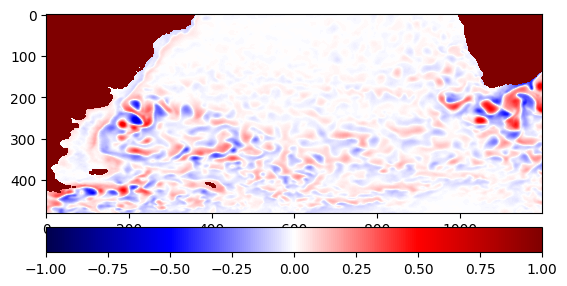

In [9]:
ssh_data_addr = (output_path_months+"/"+filename+"_"+str(year)+'_'+str(1).zfill(3)+'_'+str(month).zfill(2)+'.nc')
ssh_data = xr.open_dataset(ssh_data_addr)
ssh_data_day = ssh_data.ssh.values[0] #Reading of first data
plt.imshow(np.flipud(ssh_data_day.T), cmap=cm.seismic, vmin=-1, vmax=1)
plt.colorbar(orientation='horizontal', pad=0.04)

# Generating segmentation mask

In [10]:
#%load_ext autoreload

In [11]:
from generate_segmentation_mask import eddy
#%autoreload 2 #For debugging purpose

In [12]:
eddy_instance = eddy(dataset_path=ssh_data_addr)
seg_data_addr =  "/work/ab0995/b382485/eddy_data/segmentation_masks/seg_mask_gridded_2015_001_"+str(1).zfill(2)+"_new.nc"
eddy_instance.generate_mask(seg_data_addr)

We assume pixel position of grid is centered for /work/ab0995/b382485/eddy_data/output_path/months/ssh_filtered_gridded_2015_001_01.nc
We assume pixel position of grid is centered for /work/ab0995/b382485/eddy_data/output_path/months/ssh_filtered_gridded_2015_001_01.nc
We assume pixel position of grid is centered for /work/ab0995/b382485/eddy_data/output_path/months/ssh_filtered_gridded_2015_001_01.nc
We assume pixel position of grid is centered for /work/ab0995/b382485/eddy_data/output_path/months/ssh_filtered_gridded_2015_001_01.nc
We assume pixel position of grid is centered for /work/ab0995/b382485/eddy_data/output_path/months/ssh_filtered_gridded_2015_001_01.nc
We assume pixel position of grid is centered for /work/ab0995/b382485/eddy_data/output_path/months/ssh_filtered_gridded_2015_001_01.nc
We assume pixel position of grid is centered for /work/ab0995/b382485/eddy_data/output_path/months/ssh_filtered_gridded_2015_001_01.nc
We assume pixel position of grid is centered for /work/

# Reading the segmentation mask

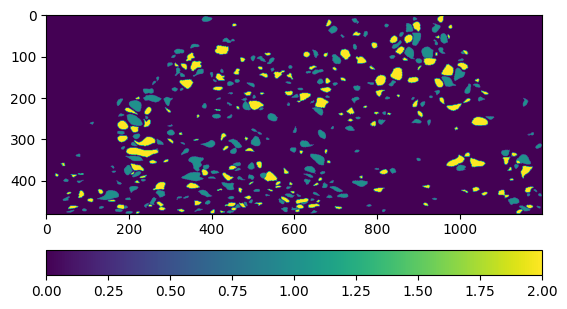

In [13]:
seg_data_addr =  "/work/ab0995/b382485/eddy_data/segmentation_masks/seg_mask_gridded_2015_001_"+str(1).zfill(2)+"_new.nc"
seg_data = xr.open_dataset(seg_data_addr)
seg_mask_true = seg_data.seg_mask.values[0] #Reading of first data
plt.imshow(np.flipud(seg_mask_true.T))
plt.colorbar(orientation='horizontal', pad=0.1)
#2 means anticyclonic
#1 means cyclonic
#0 means background

# Training the ssh data using CNN

### The CNN trainning is done by running cnn_training.py
### It is not a good idea to run training on jupyter notebook as it takes a lot of time to train

In [15]:
# Run cnn_training.py

# Testing the ssh data using the trained weights

In [16]:
from plain_neural_network import*

2023-07-01 14:11:03.981148: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [39]:
img_size = (1200, 480)
num_classes = 3
input_dir_X = output_path_months #input dir for test ssh data
weight_path = "/albedo/home/ssunar/CNN_eddy_detection/test/weights/weight" #file path for trained weight
preds_seg_mask = using_model(img_size, num_classes, input_dir_X, weight_path) # 3d matrix containing the predicted data

1/1 [==============================] - 12s 12s/step


## As the above weight is trained only for 1 month of data the results are not good

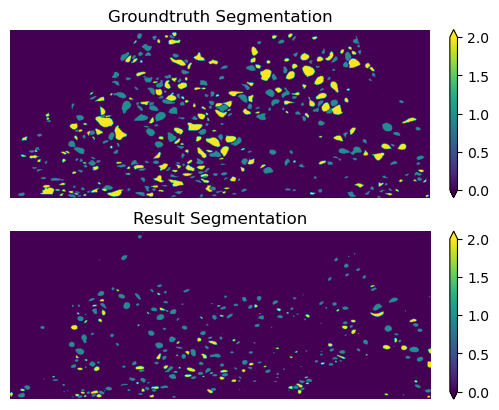

In [58]:
fig, ax = plt.subplots(2, 1)
#plt.subplot(131)
im1 = ax[0].imshow(np.flipud(seg_mask_true.T), cmap='viridis')
plt.colorbar(im1, extend='both', fraction=0.042, pad=0.04, ax = ax[0])
ax[0].axis('off')
ax[0].set_title('Groundtruth Segmentation');

#plt.figure(figsize=(90, 30))
#plt.subplot(132)
im2 = ax[1].imshow(np.flipud(preds_seg_mask[0].T), cmap='viridis')
plt.colorbar(im2, extend='both', fraction=0.042, pad=0.04, ax = ax[1])
ax[1].axis('off')
ax[1].set_title('Result Segmentation');
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Testing the ssh data using the trained weights (3 years) (Different data)

In [64]:
img_size = (1200, 480)
num_classes = 3
input_dir_X = "/albedo/home/ssunar/ssh_filtered/months" #input dir for test ssh data
weight_path = "/albedo/home/ssunar/weights_filter_new/weights" #file path for trained weight
preds_seg_mask_new = using_model(img_size, num_classes, input_dir_X, weight_path) # 3d matrix containing the predicted data

35/35 [==============================] - 510s 15s/step


In [65]:
seg_data_addr =  "/albedo/home/ssunar/segmentation_masks_3_years/segmentation_mask_nn_1961_001_01.nc"
seg_data = xr.open_dataset(seg_data_addr)
seg_mask_true = seg_data.seg_mask.values[0] #Reading of first data

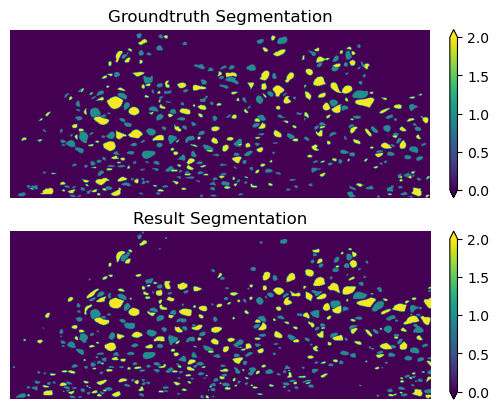

In [66]:
fig, ax = plt.subplots( 2, 1)
#plt.subplot(131)
im1 = ax[0].imshow(np.flipud(seg_mask_true.T), cmap='viridis')
plt.colorbar(im1, extend='both', fraction=0.042, pad=0.04, ax = ax[0])
ax[0].axis('off')
ax[0].set_title('Groundtruth Segmentation');

#plt.figure(figsize=(90, 30))
#plt.subplot(132)
im2 = ax[1].imshow(np.flipud(preds_seg_mask_new[0].T), cmap='viridis')
plt.colorbar(im2, extend='both', fraction=0.042, pad=0.04, ax = ax[1])
ax[1].axis('off')
ax[1].set_title('Result Segmentation');
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)